# Cerebellar volumetry analysis with GLM
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32)(34/29PassQC), PPMI/ADNI NC (116/308) (78/223PassQC).

## Tasks: GLM analysis for: 
- Comparing cerebellar volumes (left/right GM/WM)
- Compare lobular volumes ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII'; 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII'; 'Left_Dentate', 'Right_Dentate'; 
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];

## Covariates
- Age, Sex, intracranial volume (eTIV, infratentorium, cerebellar volume), site.

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import pandas as pd

data_dir = Path("/codes/tab_data")
data_all_file  = data_dir/'all_Des-cere_preped_qcInfo.csv'
matched_data_file = data_dir/'matched_Des-cere_qced.csv'
all_df     = pd.read_csv(data_all_file , sep=',', header=0, index_col=0);
matched_df = pd.read_csv(matched_data_file , sep=',', header=0, index_col=0);

In [3]:
# prepare data for this script
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
qc_list = ['freesurfer_score', 'suit_score', 'maget_score']
analysis_list = ['age','sex','group', 'cohort','site','eTIV', 'is_adni', 'is_mni', 'is_ppmi', 'male',
                 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex',
                 'Cerebellum_White_Matter', 'Cerebellum_Cortex', 'cerebellumVol', 'InfraTentorialVol']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels+qc_list;

# Select columns to analyze
matched_data_df=matched_df.loc[:,analysis_list].copy()

# Get all data with QC >= 2 in case further use.
all_data_df = all_df.loc[:,analysis_list].copy()
qc_th=2
all_data_df=all_data_df[(all_data_df['freesurfer_score']>=qc_th)&(all_data_df['suit_score']>=qc_th)&(all_data_df['maget_score']>=qc_th)].copy();

# prepare for multiple comparison
cerebellum_list = ['Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'];
lobular_list = ['Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII', 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_Dentate', 'Right_Dentate'];
df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, len(cerebellum_list)*[len(cerebellum_list)]+len(lobular_list)*[len(lobular_list)]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])
tar_list = cerebellum_list+lobular_list;

# GLM analysis for matched dataset ET/NC (34/177) (QCed)

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate';

In [4]:
# GLM for cerebellum volumetry before and after QC for MNI cohort controling difference intracranial volumes (age/sex/eTIV)
### statistical analysis
#import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df  # private lib
# stats models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts

# basic settings
alpha_=0.05

tmp_df = matched_data_df.copy() 
print("Sample sizes for ET/NC: ")
print('\t',tmp_df[tmp_df['group']=='ET'].shape[0], ' / ',tmp_df[tmp_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(tar_list))

print("\nGLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_eTIV_str);
rep_model(covariate_dict, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC: 
	 34  /  177
tested ROIs:
	 Left_Cerebellum_Cortex, Left_Cerebellum_White_Matter, Right_Cerebellum_Cortex, Right_Cerebellum_White_Matter, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate

GLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :



Left_Cerebellum_White_Matter~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC")) 

                                  Results: Generalized linear model
Model:                      GLM                                 AIC:                   3788.5445     
Link Function:              identity                            BIC:                   725822460.2987
Dependent Variable:         Left_Cerebellum_White_Matter        Log-Likelihood:        -1887.3       
Date:                       2021-12-27

In [6]:
# report effect size and significance level
# get z val 

# Control for general vis
from matplotlib.patches import Rectangle
figure_size=(22, 32);
legend_text_pos=[0.5, 0.5];
legend_font_size=26

## Cerebellar volumentry for all 3 datasets ET/NC(38/32+116+308)
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/eTIV with rm control group method;
    4. Experiment 3: control age/sex/eTIV with direct proportion adjustment method;
    6. Experiment 4: control age/sex/cerebellumVol with rm control group method;
    7. Experiment 5: control age/sex/cerebellumVol with direct proportion adjustment method;

In [7]:
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es, creat_Bonf_df
#
alpha_=5; n_permu_=5000;
# 
sts_tests_list = ['Cohen_d']; 
group_mni_list = ['ET','NC'];

# for augmented dataset
def all_vol_stats(df_all, tar_list, alpha_, n_permu_, sts_tests_list):
    # Experiment 1: without controling for any covariates;
    res_cere_gw_all = cal_es(df_all, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
    # Experiment 2: control age/sex/eTIV with rm control group method;
    dat_cere_gw_all_1, cere_gw_all_col_1 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_1 = cal_es(dat_cere_gw_all_1, cere_gw_all_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
    res_cere_gw_all_1['ROI']=res_cere_gw_all_1['ROI'].map(lambda x: x[0:-37]);
    # Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    dat_cere_gw_all_2, cere_gw_col_all_2 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_2 = cal_es(dat_cere_gw_all_2, cere_gw_col_all_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,infTV");
    res_cere_gw_all_2['ROI']=res_cere_gw_all_2['ROI'].map(lambda x: x[0:-50]);
    #Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    dat_cere_gw_all_3, cere_gw_all_col_3 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_3 = cal_es(dat_cere_gw_all_3, cere_gw_all_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
    res_cere_gw_all_3['ROI']=res_cere_gw_all_3['ROI'].map(lambda x: x[0:-36])
    #Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    dat_cere_gw_all_4, cere_gw_col_all_4 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_4 = cal_es(dat_cere_gw_all_4, cere_gw_col_all_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,infTV");
    res_cere_gw_all_4['ROI']=res_cere_gw_all_4['ROI'].map(lambda x: x[0:-36]);
    #Experiment 6: control age/sex/cerebellumVol with rm control group method;
    dat_cere_gw_all_5, cere_gw_col_all_5 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_5 = cal_es(dat_cere_gw_all_5, cere_gw_col_all_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
    res_cere_gw_all_5['ROI']=res_cere_gw_all_5['ROI'].map(lambda x: x[0:-46]);
    #Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;
    dat_cere_gw_all_6, cere_gw_all_col_6 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_6 = cal_es(dat_cere_gw_all_6, cere_gw_all_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
    res_cere_gw_all_6['ROI']=res_cere_gw_all_6['ROI'].map(lambda x: x[0:-36]);
    res_method_all_df=pd.concat([res_cere_gw_all, res_cere_gw_all_1, res_cere_gw_all_2, res_cere_gw_all_5, res_cere_gw_all_3, res_cere_gw_all_4, res_cere_gw_all_6])
    return res_method_all_df

# Matched cohort after QC
tmp_matched_data_df = matched_data_df.copy()
matched_method_df = all_vol_stats(tmp_matched_data_df, tar_list, alpha_, n_permu_, sts_tests_list);
# All cohort after QC
#all_method_df = all_vol_stats(data_qc_df, tar_list, alpha_, n_permu_, sts_tests_list);

Using  rm_norm
New columns 13 :  ['Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni']
Using  rm_norm
New columns 13 :  ['Left_Cerebellum_Cortex_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_InfraTentor

In [ ]:
# This is the figure created for 2022 OHBM abstract about our priliminary results.
#
figure_size=(20, 30);
legend_text_pos=[-0.25, -0.04];
legend_font_size=26

C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']

vis_df = matched_method_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)

drop_cols=[2,5]; drop_rows=[4, 5];
es_df_.drop(es_df_.index[drop_rows], axis=0, inplace=True);
anno_df.drop(anno_df.index[drop_rows], axis=0, inplace=True);
es_df_.drop(es_df_.columns[drop_cols], axis=1, inplace=True);
anno_df.drop(anno_df.columns[drop_cols], axis=1, inplace=True);
xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])] +['Literature Findings']
es_df_.loc[:,'literature']  = 13*[-1]+4*[0];
anno_df.loc[:,'literature'] = 13*['atrophy']+4*['None'];

# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2)
ax2.set_xlabel("Methods variations")
ax2.set_title('Cerebellum regional volume differences between ET and NC across correction methods\n in the matched augmented cohort', fontsize=32)
#for _, spine in ax2.spines.items(): spine.set_visible(True)

# adding more repliccability information (need QC done)
lit_roi_all=[(2,2), (4,2)]
for x_ in lit_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

conflict_roi_all=[(1,1), (2,1),(3,1),(4,1) ]+[(1,7),(1,8),(1,16)]+[(2,7),(2,16)]
for x_ in conflict_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
line_pos=[4,13]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
plt.axvline(5, ls='--',c='k', lw=3)

## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, cohort, eTIV',
    r'Method 3: Control for age, sex, cohort, Cerebellum Volume',
    r'Method 4: Control for age, sex, cohort, direct proportion adjustment with eTIV',
    r'Method 5: Control for age, sex, cohort, direct proportion adjustment with Cerebellum Volume',
    r'Literature: Blue: Atrophy; White: No findings; Red: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props)
plt.show()
f2.savefig("matched-corhorts_qc_methods-Sensitivity_non-parametric_ohbm_abs.jpg")

# GLM analysis for augmented dataset ET/NC (38/32+116+308) (QC pass:34/29+223+78)


1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate';

In [4]:
# GLM for cerebellum volumetry before and after QC for Aug-cohort controling difference intracranial volumes (age/sex/eTIV)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

# basic settings
alpha_=0.05

tmp_qc_df = all_data_df.copy()
print("Sample sizes for ET/NC: ")
print('\t',tmp_qc_df[tmp_qc_df['group']=='ET'].shape[0], ' / ',tmp_qc_df[tmp_qc_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(tar_list))

# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
print("\nGLM for cerebellum volumetry (age/sex/eTIV) on all qced cohort:")
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_qc = glm_test(tmp_qc_df, tar_list, covariate_model_eTIV_str);
rep_model(covariate_dict, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry (age/sex/cohort/cerebellumVol) on all qced cohort
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on all qced:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_qc_df, tar_list, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC: 
	 34  /  330
tested ROIs:
	 Left_Cerebellum_Cortex, Left_Cerebellum_White_Matter, Right_Cerebellum_Cortex, Right_Cerebellum_White_Matter, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate

GLM for cerebellum volumetry (age/sex/eTIV) on all qced cohort:
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :



Left_Cerebellum_White_Matter~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC")) 

                                  Results: Generalized linear model
Model:                      GLM                                 AIC:                   3788.5445     
Link Function:              identity                            BIC:                   725822460.2987
Dependent Variable:         Left_Cerebellum_White_Matter        Log-Likelihood:        -1887.3       
Date:                       2021-12-2

,eTIV,SupraTentorialVol,InfraTentorialVol,cerebellumVol
eTIV,1.000000,0.841576,0.794829,0.580482
SupraTentorialVol,0.841576,1.000000,0.341134,0.696672
InfraTentorialVol,0.794829,0.341134,1.000000,0.227529
cerebellumVol,0.580482,0.696672,0.227529,1.000000


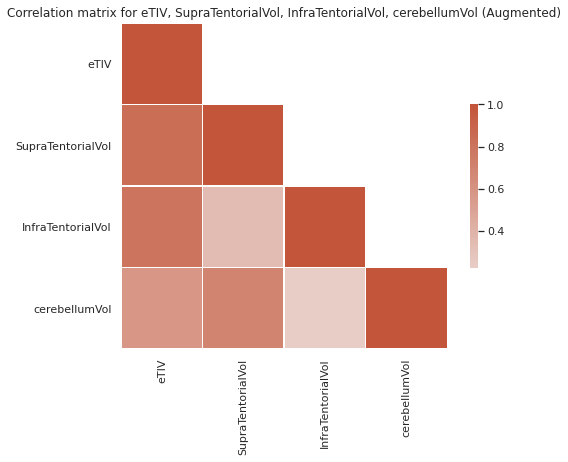

In [5]:
# Deprecated: report correlation between the intracranial volumes for controling
vol_list = ['eTIV', 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol'];
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Augmented dataset
corr_df=all_data_df[vol_list]
corr_=corr_df.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0, xticklabels=vol_list, yticklabels=vol_list,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol (Augmented)')
display(corr_)